In [1]:
# %%
# requirement
#torch
#lightning
#wandb

# %%
# CONFIG
from argparse import Namespace
args = Namespace(
    # data
    sample_size = 100_000,
    seq_len = 100, 
    n_ids = 100, # equal to seq_len, eg: 200 SNP sites
    n_classes = 13, # masked, AA, AT, AC, AG, CA, CT, GA, GC, TA, TC, TG, TT
    
    # model
    MAX_EPOCHS = 20,
    batch_size = 100,
    n_layers=4,
    n_heads=4,
    d_model=16,
    d_ffn=16*4,
    dropout=0.05,
    
    # training
    mask_frac=0.15,
    fix_lr = True,
    lr=1e-3,
    lr_warmup = 20,
    lr_max_iters = 200,
    ckpt_dir = './ckpt',
    ckpt_filename = 'min_val_loss',
    ckpt_resume = True,
)

# IMPORT LIBRARIES
import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
torch.set_float32_matmul_precision('high') # 'medium' or 'high'
import lightning as L
from encoder_pytorch_modified import get_encoder
# from scipy.stats import pearsonr
import math
import wandb
import matplotlib.pyplot as plt
import numpy as np


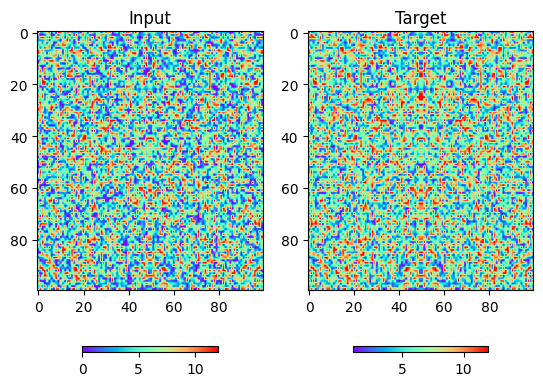

In [2]:

# %%
# --------------------------------
# Step 1: Create data for testing
# --------------------------------
class GenerateDataset(data.Dataset):
    def __init__(self, args):
        super().__init__()
        n_ids = args.n_ids
        n_classes = args.n_classes
        seq_len = args.seq_len
        sample_size = args.sample_size
        self.sample_size = sample_size
        self.ids = []
        self.input_values = []
        self.target_values = []
        for _ in range(sample_size):
            ids = torch.arange(n_ids).reshape(1, n_ids)
            values = torch.randint(low=1, high=n_classes, size=(1, seq_len))
            # make 2nd half of sequence equal to 1st half
            half_len = seq_len // 2
            values[:, half_len:] = values[:, :half_len].flip(1)
            # masking 15% of values as zeros
            mask = torch.rand(size=(1, seq_len)) < args.mask_frac
            masked_values = torch.where(mask, torch.zeros_like(values), values)
            self.ids.append(ids)
            self.input_values.append(masked_values)
            self.target_values.append(values)
        self.ids = torch.cat(self.ids)
        self.input_values = torch.cat(self.input_values)
        self.target_values = torch.cat(self.target_values)

    def __len__(self):
        return self.sample_size
    
    def __getitem__(self, idx):
        ids = self.ids[idx]
        input_values = self.input_values[idx]
        target_values = self.target_values[idx]
        return ids, input_values, target_values

from torch.utils.data import random_split, DataLoader

class GeneratedDataModule(L.LightningDataModule):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.batch_size = args.batch_size
        
    def setup(self, stage: str):
        ds_full = GenerateDataset(self.args)
        self.ds_train, self.ds_val = random_split(
            ds_full, [0.9, 0.1], generator=torch.Generator().manual_seed(42)
        )

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size, num_workers=15, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size, num_workers=15)


# %%
dm = GeneratedDataModule(args)
dm.setup(stage="fit")
train_loader = dm.train_dataloader()

# plot example batch
# get 1 batch of data 
ids, x, y = next(iter(train_loader))
cmap='rainbow'
fig, axs = plt.subplots(1,2)
axs[0].title.set_text('Input')
axs[1].title.set_text('Target')
fig.colorbar(axs[0].imshow(x[:args.batch_size,:].numpy(),cmap=cmap, aspect='auto'), ax=axs[0], shrink=0.6, orientation='horizontal')
fig.colorbar(axs[1].imshow(y[:args.batch_size,:].numpy(),cmap=cmap, aspect='auto'), ax=axs[1], shrink=0.6, orientation='horizontal')
plt.savefig('example_batch.png')
plt.show()
plt.close()


In [3]:

# %%
# --------------------------------
# Step 2: Define BERT model
# --------------------------------
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

class embedding_int(nn.Module):
    def __init__(self, max_int, d_embed):
        super().__init__()
        self.d_embed = d_embed
        self.embed = nn.Embedding(max_int, d_embed)
    def forward(self, x):
        # (batch, seq_len) -> (batch, seq_len, d_embed)
        embeded = self.embed(x) * math.sqrt(self.d_embed) 
        return embeded

class pl_model(L.LightningModule):
    def __init__(self, args):
        super().__init__()
        d_embed_id = args.d_model
        d_embed_class = args.d_model
        d_model = args.d_model
        self.args = args
        self.id_embedding = embedding_int(args.n_ids, d_embed_id) 
        self.class_embedding = embedding_int(args.n_classes, d_embed_class)
        self.correct_dim = nn.Sequential(
            nn.Linear(d_embed_id+d_embed_class, d_model),
            nn.Dropout(args.dropout),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
        )
        self.encoder = get_encoder(args)
        # self.decoder = nn.Linear(d_model, 1)
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Dropout(args.dropout),
            nn.ReLU(),
            nn.Linear(d_model, args.n_classes),
        )
        self.validation_outputs = []
        
    def forward(self, id, x):
        # x.shape: (batch, seq_len)        
        batch, seq_len = x.shape
        id = self.id_embedding(id)
        x = self.class_embedding(x)
        # x.shape: (batch, seq_len, d_embed)        
        x = torch.cat([id, x], dim=2)
        x = self.correct_dim(x)
        # x = x + id
        x = self.encoder(x)
        y_hat = self.decoder(x)
        return y_hat
    
    def forward_w_attn(self, id, x):
        batch, seq_len = x.shape
        id = self.id_embedding(id)
        x = self.class_embedding(x)
        # x.shape: (batch, seq_len, d_embed)        
        x = torch.cat([id, x], dim=2)
        x = self.correct_dim(x)
        # x = x + id
        x, attn_maps = self.encoder.forward_w_attn(x)
        y_hat = self.decoder(x)
        return y_hat, attn_maps
    
    def _calculate_loss_acc(self, batch):
        id, x, y = batch
        y_hat = self(id, x)
        y = y.reshape(-1)
        y_hat = y_hat.reshape(-1, args.n_classes)
        # only select masked position to calculate loss and acc
        mask = x == 0
        mask = mask.reshape(-1)
        y = y[mask]
        # add 1 dim to make it 2 dim
        # mask = mask.unsqueeze(-1)
        # repeat over 2nd dim
        # mask = mask.repeat(1, args.n_classes)
        y_hat = y_hat[mask,:]
        loss = F.cross_entropy(y_hat, y)
        acc = y_hat.argmax(dim=1).eq(y).sum().item() / y.shape[0]
        return(loss, acc)
    
    def training_step(self, batch, batch_idx):
        loss, acc = self._calculate_loss_acc(batch)
        self.log("train/loss", loss, prog_bar=True)
        self.log("train/acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        id, x, y = batch
        y_hat = self(id, x)
        y = y.reshape(-1) 
        y_hat = y_hat.reshape(-1, args.n_classes)
        # only select masked position to calculate loss and acc
        mask = x == 0
        mask = mask.reshape(-1)
        y = y[mask]
        y_hat = y_hat[mask,:]

        self.validation_outputs.append((y_hat, y))
        loss = F.cross_entropy(y_hat, y)
        acc = y_hat.argmax(dim=1).eq(y).sum().item() / y.shape[0]
        self.log("val/loss", loss, prog_bar=True, sync_dist=True)
        self.log("val/acc", acc, prog_bar=True, sync_dist=True)
        return loss
    
    def on_validation_start(self):
        self.validation_outputs = []
    
    def on_validation_epoch_end(self):
        y_hat, y = zip(*self.validation_outputs)
        y_hat = torch.cat(y_hat)
        y = torch.cat(y)
        y = y.reshape(-1)
        y_hat = y_hat.reshape(-1, args.n_classes)
        acc = y_hat.argmax(dim=1).eq(y).sum().item() / y.shape[0]
        # add a little bit noise 
        y_hat = y_hat.argmax(dim=1).float()
        y = y.float()
        y_hat = y_hat + torch.randn_like(y_hat) * 0.1
        y = y + torch.randn_like(y) * 0.1
        # scatter plot y_hat vs y
        plt.figure()
        plt.scatter(y.detach().cpu().numpy().flatten(), y_hat.detach().cpu().numpy().flatten(), alpha=0.3, s=0.3)
        plt.xlabel("expectation")
        plt.ylabel("prediction")
        plt.title(f"y vs y_hat, epoch: {self.current_epoch}, corr: {acc:.3f}")
        # plt.show()
        plt.savefig("y_vs_y_hat.png")
        
    def test_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        loss, acc = self._calculate_loss_acc(batch)
        self.log("test/loss", loss, prog_bar=True, sync_dist=True)
        self.log("test/acc", acc, prog_bar=True, sync_dist=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.args.lr)
        if self.args.fix_lr:
            return optimizer
        else:
            # Apply lr scheduler per step
            lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.args.lr_warmup,
                                             max_iters=self.args.lr_max_iters)
            return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]
   


In [4]:

# %%
# -------------------
# Step 3: Train
# -------------------

from lightning.pytorch.loggers import WandbLogger
logger = WandbLogger(project='test', name='', config=args, tags=[], save_code=True, settings=wandb.Settings(code_dir=".")) 
import os
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor 
lr_monitor = LearningRateMonitor(logging_interval='step')

model = pl_model(args)
trainer = L.Trainer(
    # strategy="ddp_find_unused_parameters_true",
    # strategy = 'ddp',
    accelerator='gpu',
    devices='auto', 
    # devices=[0,1], 
    max_epochs=args.MAX_EPOCHS, 
    # logger=logger, 
    # log_every_n_steps=10,
    callbacks=[
        ModelCheckpoint(monitor='val/loss', mode='min', save_top_k=1, dirpath=args.ckpt_dir, filename=args.ckpt_filename, enable_version_counter=False, verbose=True),
        lr_monitor],
)


# if ckpt file exists, resume training
ckpt_path = args.ckpt_dir + '/' + args.ckpt_filename + '.ckpt'
if args.ckpt_resume and os.path.exists(ckpt_path):
    print(f'Resuming training from {ckpt_path}')
    trainer.fit(model, dm, ckpt_path=ckpt_path)
else:
    trainer.fit(model, dm)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Resuming training from ./ckpt/min_val_loss.ckpt


/home/augix/miniconda/envs/mamba/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/nas/augix/sandbox/snp_test/ckpt exists and is not empty.
Restoring states from the checkpoint path at ./ckpt/min_val_loss.ckpt


RuntimeError: Error(s) in loading state_dict for pl_model:
	size mismatch for id_embedding.embed.weight: copying a param with shape torch.Size([20, 16]) from checkpoint, the shape in current model is torch.Size([100, 16]).

In [ ]:
# -------------------
# Step 4: Plot results
# -------------------
# %% [markdown]
# # plot attention maps

# %%
one_batch = next(iter(train_loader))
id, input, target = one_batch
pred, attn = model.forward_w_attn(id, input)

input = input.detach().cpu().numpy()
pred = pred.argmax(dim=2).detach().cpu().numpy()
target = target.detach().cpu().numpy()

# heatmap
cmap='rainbow'
fig, axs = plt.subplots(1,3)
axs[0].title.set_text('Input')
axs[1].title.set_text('Target')
axs[2].title.set_text('Prediction')
fig.colorbar(axs[0].imshow(input,cmap=cmap, aspect='auto'), ax=axs[0], shrink=0.6, orientation='horizontal')
fig.colorbar(axs[1].imshow(target,cmap=cmap, aspect='auto'), ax=axs[1], shrink=0.6, orientation='horizontal')
fig.colorbar(axs[2].imshow(pred,cmap=cmap, aspect='auto'), ax=axs[2], shrink=0.6, orientation='horizontal')
plt.savefig('predictions.png')
plt.show()
plt.close()


In [ ]:

# %%
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size), dpi=300)
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    avg_attn = np.zeros((seq_len, seq_len))
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower')
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist(), fontsize=4)
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist(), fontsize=4)
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
            avg_attn += attn_maps[row][column]
    fig.subplots_adjust(hspace=0.5)
    plt.savefig('attn_maps.png')
    plt.show()
    plt.close()
    
    avg_attn /= num_heads*num_layers
    plt.figure(dpi=300)
    plt.imshow(avg_attn, origin='lower')
    plt.xticks(list(range(seq_len)), fontsize=4)
    plt.yticks(list(range(seq_len)), fontsize=4)
    plt.colorbar()
    # ax[row][column].set_xticks(list(range(seq_len)))
    # ax[row][column].set_xticklabels(input_data.tolist())
    plt.title('average attention map')
    plt.savefig('avg_attn_map.png')
    plt.show()
    plt.close()
    return avg_attn


# %%
avg_attn = plot_attention_maps(id, attn, idx=0)
print(f'avg_attn.shape: {avg_attn.shape}')